<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/SVM_Group_Whole_Brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Whole Brain Support Vector Machine Training
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- load local pickle file containing all masked, normalized Whole Brain subject data in numpy matrix format
- SVM training per group (subject ids of '100XX-XXXXX' for child and '300XX-XXXXX' for Youth)

### Mount Google Drive and clone repository
- open to source directory

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source
!ls


fatal: destination path 'teambrainiac' already exists and is not an empty directory.
/content/teambrainiac/source
 Access_Load_Data.ipynb		    percent_signal_change.ipynb
 All_subject_masked_labeled.ipynb   __pycache__
 data				    SVM_Group_Whole_Brain.ipynb
 __init__.py			    SVM.ipynb
 Masking.ipynb			    SVM_Whole_Brain.ipynb
 Mat_to_Numpy.ipynb		    utils.py
 models				    Visualize_Data.ipynb
 path_config.py			   'Viz ROI.ipynb'


### Load path_config.py 
- we are already in source so we can just load this file without chanding directory

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


### Load the Whole brain normalized masked all subject 2d pickle file 


In [ ]:
!ls

Access_Load_Data.ipynb		  path_config.py
All_subject_masked_labeled.ipynb  percent_signal_change.ipynb
data				  SVM.ipynb
__init__.py			  SVM_Whole_Brain.ipynb
Masking.ipynb			  utils.py
Mat_to_Numpy.ipynb		  Visualize_Data.ipynb


#### Import libraries


In [3]:
# Import libraries
!pip install boto3 nilearn
import pickle
from utils import *
from sklearn.svm import SVC
import numpy as np
import random
import cv2 as cv
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

### Load Data from AWS and create Train/Val/Test splits

In [4]:
%%time
pkl_file = "whole_brain_all_norm_2d.pkl" # normalized
#pkl_file = 'all_data_dictionary.pkl' #Unnormalized
bool_mat = False
data = access_load_data(pkl_file, bool_mat)

CPU times: user 1min 21s, sys: 2min 4s, total: 3min 26s
Wall time: 2min 46s


In [5]:

 #open path dictionary file to get subject ids
path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(path)
subject_ids = data_path_dict['subject_ID']



In [6]:
mask_data_path = data_path_dict['mask_data'][0]
mask_type_dict = access_load_data(mask_data_path,True)
np_array_mask = mask_type_dict['mask']

In [7]:
np_array_mask.shape

(79, 95, 79)

In [8]:
indices_mask = np.where(np_array_mask==1) # gets the indices where the mask is 1, the brain region for x, y, z planes
indices_mask

(array([ 3,  3,  3, ..., 75, 75, 75]),
 array([36, 36, 36, ..., 47, 47, 47]),
 array([33, 34, 35, ..., 28, 29, 30]))

In [9]:
# Split dataset into young children and older children/young adults
child = subject_ids[:33]
teen_plus = subject_ids[33:]
print("Number of subjects for child and teens", len(child), len(teen_plus))


Number of subjects for child and teens 33 19


# Child

In [76]:
# get train, test val data
c_train_ids = child[:23]
c_val_ids = child[23:28]
c_test_ids = child[28:34]

print("Number of child training examples: ", len(c_train_ids))
print("Number of child validation examples: ", len(c_val_ids))
print("Number of child testing examples: ", len(c_test_ids))
len(child)

Number of child training examples:  23
Number of child validation examples:  5
Number of child testing examples:  5


33

In [77]:
# Get train test val data 
X_trainc = []
y_trainc = []

X_valc = []
y_valc = []

X_testc = []
y_testc = []

run = 1 # Get data from run #2

# Get X data from dictionary
for id_ in c_train_ids:
  X_trainc.append(data[id_][run])
        
        
# Get y label from dictioanry
for id_ in c_train_ids:
  y_trainc.append(data[f"{id_}_rt_labels"][run])
        


# Get X data from dictionary
for id_ in c_val_ids:
  X_valc.append(data[id_][run])
 

# Get y label from dictioanry
for id_ in c_val_ids:
  y_valc.append(data[f"{id_}_rt_labels"][run])
        
    

# Get X data from dictionary
for id_ in c_test_ids:
  X_testc.append(data[id_][run])
        
        
# Get y label from dictioanry
for id_ in c_test_ids:
  y_testc.append(data[f"{id_}_rt_labels"][run])

In [78]:
# 1 run * 33 * 84 = 2772 total time points
print(f"length of Child Xtrain data: {len(X_trainc)} and length of ytrain data: {len(y_trainc)}")
print(f"length of Child Xval data: {len(X_valc)} and length of yval data: {len(y_valc)}")
print(f"length of Child Xtest data: {len(X_testc)} and length of ytest data: {len(y_testc)}")
#print(f"length of X data: {len(X)} and length of y data: {len(y)}")

length of Child Xtrain data: 23 and length of ytrain data: 23
length of Child Xval data: 5 and length of yval data: 5
length of Child Xtest data: 5 and length of ytest data: 5


In [79]:
%%time
X_trainc = np.array(X_trainc)
y_trainc = np.array(y_trainc)
print( "Child Xtrain data shape ", X_trainc.shape)
print( "Child ytrain data shape ", y_trainc.shape)

X_valc = np.array(X_valc)
y_valc = np.array(y_valc)
print( "Child Xval data shape ", X_valc.shape)
print( "Child yval data shape ", y_valc.shape)

X_testc = np.array(X_testc)
y_testc = np.array(y_testc)
print( "Child Xtest data shape ", X_testc.shape)
print( "Child ytest data shape ", y_testc.shape)

Child Xtrain data shape  (23, 84, 237979)
Child ytrain data shape  (23, 84)
Child Xval data shape  (5, 84, 237979)
Child yval data shape  (5, 84)
Child Xtest data shape  (5, 84, 237979)
Child ytest data shape  (5, 84)
CPU times: user 2.85 s, sys: 3.38 s, total: 6.23 s
Wall time: 6.2 s


In [80]:
%%time
X_trainc = np.concatenate(X_trainc)
y_trainc = np.concatenate(y_trainc)
print( "Child Xtrain data shape after concantenation ", X_trainc.shape)
print( "Child ytrain data shape after concantenation ", y_trainc.shape)

X_valc = np.concatenate(X_valc)
y_valc = np.concatenate(y_valc)
print( "Child Xval data shape after concantenation ", X_valc.shape)
print( "Child yval data shape after concantenation ", y_valc.shape)

X_testc = np.concatenate(X_testc)
y_testc = np.concatenate(y_testc)
print( "Child Xtest data shape after concantenation ", X_testc.shape)
print( "Child ytest data shape after concantenation ", y_testc.shape)

Child Xtrain data shape after concantenation  (1932, 237979)
Child ytrain data shape after concantenation  (1932,)
Child Xval data shape after concantenation  (420, 237979)
Child yval data shape after concantenation  (420,)
Child Xtest data shape after concantenation  (420, 237979)
Child ytest data shape after concantenation  (420,)
CPU times: user 537 ms, sys: 1.12 s, total: 1.65 s
Wall time: 1.61 s


## Organize Data Child for Cross Validation
If we are performing cross validation, we need to get the data without splitting first

In [12]:
# Get train and labels
X = []
y = []

run = 1 # Get data from run #2

# Get X data from dictionary
for id_ in child:
  X.append(data[id_][run])
        
        
# Get y label from dictioanry
for id_ in child:
  y.append(data[f"{id_}_rt_labels"][run])

print(f"Length of Child data {len(X)} and labels {len(y)}")

Length of Child data 33 and labels 33


In [13]:
%%time
X_c = np.array(X)
y_c = np.array(y)
print( "Child X data shape ", X_c.shape)
print( "Child y data shape ", y_c.shape)

Child X data shape  (33, 84, 237979)
Child y data shape  (33, 84)
CPU times: user 553 ms, sys: 499 ms, total: 1.05 s
Wall time: 1.05 s


In [14]:
%%time
X_c = np.concatenate(X_c)
y_c = np.concatenate(y_c)
print( "Child X data shape after concantenation ", X_c.shape)
print( "Child y data shape after concantenation ", y_c.shape)

Child X data shape after concantenation  (2772, 237979)
Child y data shape after concantenation  (2772,)
CPU times: user 494 ms, sys: 521 ms, total: 1.01 s
Wall time: 1.01 s


### Plot Distribution of first 5 subjects sanity check

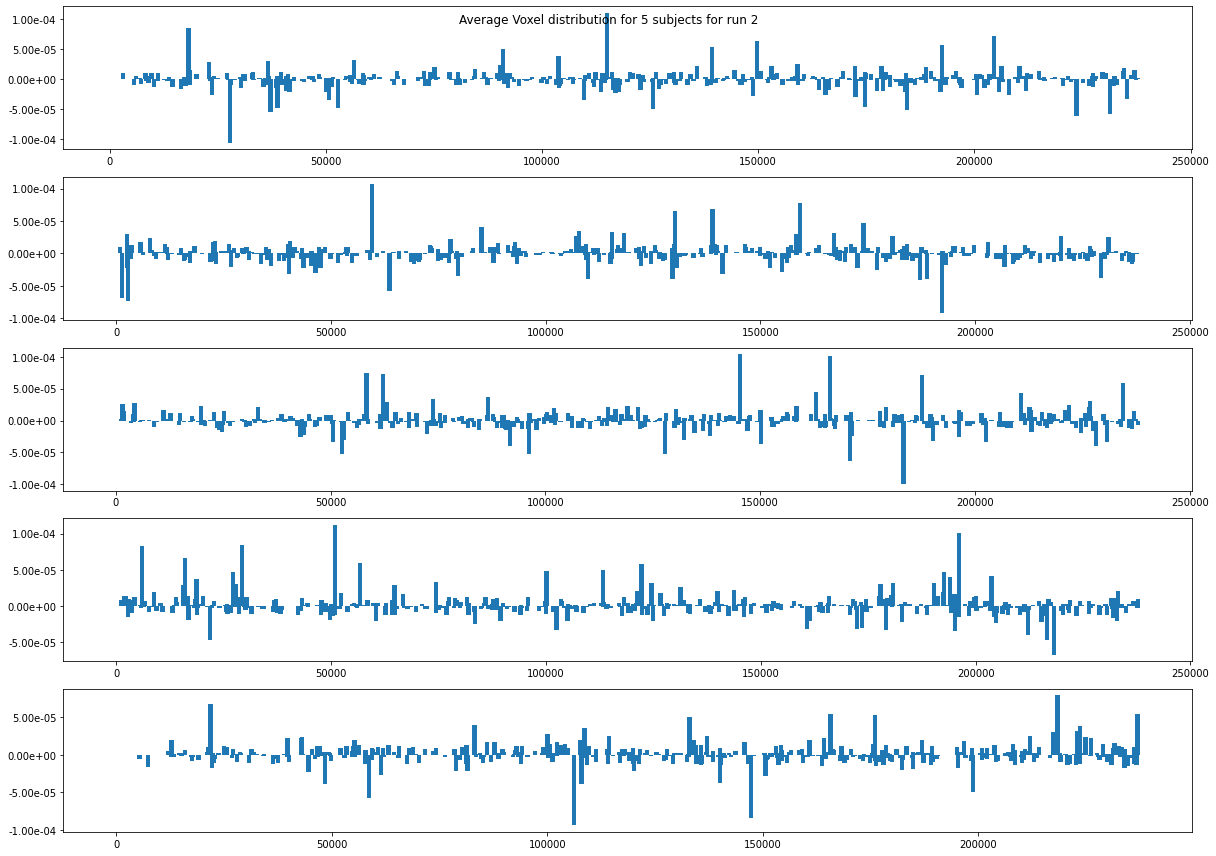

In [131]:
import matplotlib.pyplot as plt
n_sub = 5
fig, axs = plt.subplots(len(X[:n_sub]))
fig.set_figheight(12)
fig.set_figwidth(17)
#fig.figure(figsize = (10 ,3))
fig.suptitle(f'Average Voxel distribution for {n_sub} subjects for run {run + 1}')
#fig.title(f"Average Voxel distribution for subject {ind}")

for indx, matrix in enumerate(X[:n_sub]):
  av = np.mean(matrix, axis = 0)
  x_ax = np.sort(np.random.randint(0, len(av), 500))
  y_ax = av[x_ax]
  
  axs[indx].bar(x_ax, y_ax, width=1000)
  
  #plt.xlabel("voxel number")
  #plt.ylabel("Normalized Voxel Signal Values per subject per run")
axs[0].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
axs[1].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
axs[2].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
axs[3].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
axs[4].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
plt.savefig('data/five_sub_run{run + 1}_vox_dist.png')
fig.tight_layout()

#### Plot distribution of first 4 runs of first subject

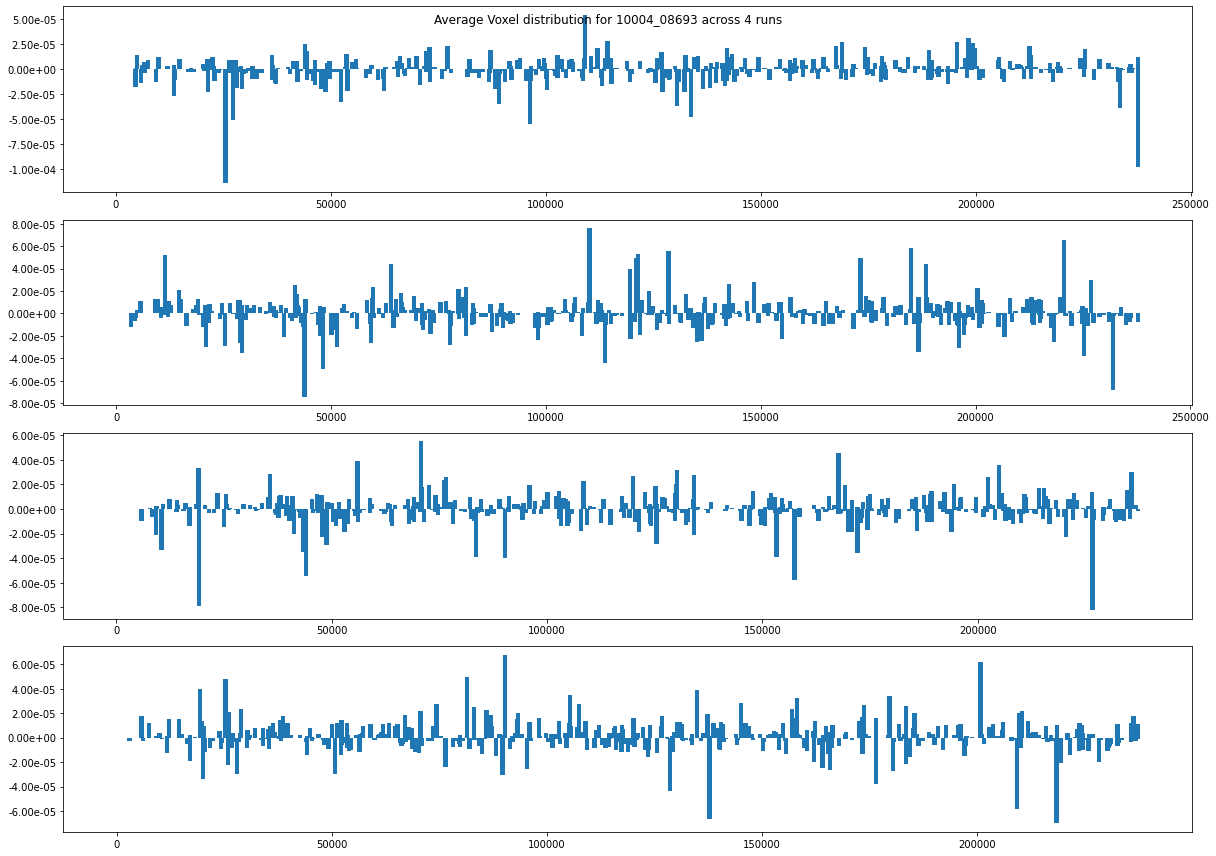

In [73]:
subject = list(data.keys())[0]
X_single_4run = data[subject]
fig, axs = plt.subplots(len(X_single_4run))
fig.set_figheight(12)
fig.set_figwidth(17)
#fig.figure(figsize = (10 ,3))
fig.suptitle(f'Average Voxel distribution for {subject} across {len(X_single_4run)} runs')
#fig.title(f"Average Voxel distribution for subject {ind}")

for indx, matrix in enumerate(X_single_4run):
  av = np.mean(matrix, axis = 0)
  x_ax = np.sort(np.random.randint(0, len(av), 500))
  y_ax = av[x_ax]
  
  axs[indx].bar(x_ax, y_ax, width=1000)

  
  #plt.xlabel("voxel number")
  #plt.ylabel("Normalized Voxel Signal Values per subject per run")
axs[0].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
axs[1].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
axs[2].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
axs[3].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
plt.savefig('data/single_sub_vox_dist.png')
fig.tight_layout()

### SVM Child Cross Validation

In [14]:
%%time
clf = SVC(max_iter = 1000, random_state = 42)

CPU times: user 23 µs, sys: 26 µs, total: 49 µs
Wall time: 52.5 µs


In [15]:
%%time
scores = cross_val_score(clf, X_c, y_c, cv=5, scoring = 'f1_macro', n_jobs = 2)
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.402 accuracy with a standard deviation of 0.070
CPU times: user 25.8 s, sys: 4.34 s, total: 30.1 s
Wall time: 1h 5min 42s


# SVM Model Prediction for Children

#### SKlearn model training on Group data for Child

In [81]:
%%time

model_name = "group_child_svm_1000"
clf = SVC(C = 0.1, max_iter = 1000, random_state = 42)
clf.fit(X_trainc, y_trainc)
f = open("models/%s.pkl"%model_name,"wb")
pickle.dump(clf, f)
f.close()

CPU times: user 22min 50s, sys: 7min 9s, total: 29min 59s
Wall time: 4min 17s


In [82]:
%%time
yval_pred = clf.predict(X_valc)


CPU times: user 19min 33s, sys: 47min 59s, total: 1h 7min 33s
Wall time: 8min 46s


In [83]:
# Model Accuracy
print("Accuracy:", accuracy_score(y_valc, yval_pred))

Accuracy: 0.5761904761904761


#### Predict on held out test data

In [84]:
%%time
ytest_pred = clf.predict(X_testc)

# Model Accuracy
print("Accuracy:", accuracy_score(y_testc, ytest_pred))

Accuracy: 0.5261904761904762
CPU times: user 18min 53s, sys: 44min 30s, total: 1h 3min 24s
Wall time: 7min 59s


#### Check Support Vectors

In [93]:
print("number of support vectors:", len(clf.support_))
clf.support_ #Indices of support vectors

number of support vectors: 1932


array([  14,   15,   16, ..., 1922, 1923, 1924], dtype=int32)

In [86]:
clf.dual_coef_

array([[-0.1, -0.1, -0.1, ...,  0.1,  0.1,  0.1]])

In [87]:
clf.dual_coef_.shape

(1, 1932)

In [94]:
clf.support_.shape


(1932,)

#### Create Alphas

In [95]:
alphas = np.zeros((1932)) #create empty array
alphas.shape

(1932,)

In [96]:
alphas[clf.support_] = clf.dual_coef_ #Load the weights corresponding to where support vectors are 
alphas.shape

(1932,)

In [97]:
alphas = alphas.reshape(1,-1)
alphas.shape

(1, 1932)

#### Create Beta Map

In [ ]:
bmap = np.dot(alphas,X_trainc) # create Beta Map
bmap.shape

In [ ]:
bmap2 = np.zeros((79,95,79))
bmap2[indices_mask] = bmap

# Young Adults

In [10]:
# get train, test val data
y_train_ids = teen_plus[:13]
y_val_ids = teen_plus[13:16]
y_test_ids = teen_plus[16:20]

print("Number of Youth training examples: ", len(y_train_ids))
print("Number of Youth validation examples: ", len(y_val_ids))
print("Number of Youth testing examples: ", len(y_test_ids))
len(teen_plus)

Number of Youth training examples:  13
Number of Youth validation examples:  3
Number of Youth testing examples:  3


19

In [11]:
# Get train test val data 
X_trainy = []
y_trainy = []

X_valy = []
y_valy = []

X_testy = []
y_testy = []

run = 1 # get run #2

# Get X data from dictionary
for id_ in y_train_ids:
  X_trainy.append(data[id_][run])
        
        
# Get y label from dictioanry
for id_ in y_train_ids:
  y_trainy.append(data[f"{id_}_rt_labels"][run])
        

# Get X data from dictionary
for id_ in y_val_ids: 
  X_valy.append(data[id_][run])
        
        
# Get y label from dictioanry
for id_ in y_val_ids:
  y_valy.append(data[f"{id_}_rt_labels"][run])
        
    

# Get X data from dictionary
for id_ in y_test_ids:
  X_testy.append(data[id_][run])
        
        
# Get y label from dictioanry
for id_ in y_test_ids:
  y_testy.append(data[f"{id_}_rt_labels"][run])
        
      

In [12]:
# 1 * 19 * 84 = 1596 time points total
print(f"length of Youth Xtrain data: {len(X_trainy)} and length of ytrain data: {len(y_trainy)}")
print(f"length of Youth Xval data: {len(X_valy)} and length of yval data: {len(y_valy)}")
print(f"length of Youth Xtest data: {len(X_testy)} and length of ytest data: {len(y_testy)}")
#print(f"length of X data: {len(X)} and length of y data: {len(y)}")

length of Youth Xtrain data: 13 and length of ytrain data: 13
length of Youth Xval data: 3 and length of yval data: 3
length of Youth Xtest data: 3 and length of ytest data: 3


In [13]:
%%time
X_trainy = np.array(X_trainy)
y_trainy = np.array(y_trainy)
print( "Youth Xtrain data shape ", X_trainy.shape)
print( "Youth ytrain data shape ", y_trainy.shape)

X_valy = np.array(X_valy)
y_valy = np.array(y_valy)
print( "Youth Xval data shape ", X_valy.shape)
print( "Youth yval data shape ", y_valy.shape)

X_testy = np.array(X_testy)
y_testy = np.array(y_testy)
print( "Youth Xtest data shape ", X_testy.shape)
print( "Youth ytest data shape ", y_testy.shape)

Youth Xtrain data shape  (13, 84, 237979)
Youth ytrain data shape  (13, 84)
Youth Xval data shape  (3, 84, 237979)
Youth yval data shape  (3, 84)
Youth Xtest data shape  (3, 84, 237979)
Youth ytest data shape  (3, 84)
CPU times: user 346 ms, sys: 1.4 s, total: 1.74 s
Wall time: 1.72 s


In [14]:
%%time
X_trainy = np.concatenate(X_trainy)
y_trainy = np.concatenate(y_trainy)
print( "Youth Xtrain data shape after concantenation ", X_trainy.shape)
print( "Youth ytrain data shape after concantenation ", y_trainy.shape)

X_valy = np.concatenate(X_valy)
y_valy = np.concatenate(y_valy)
print( "Youth Xval data shape after concantenation ", X_valy.shape)
print( "Youth yval data shape after concantenation ", y_valy.shape)

X_testy = np.concatenate(X_testy)
y_testy = np.concatenate(y_testy)
print( "Youth Xtest data shape after concantenation ", X_testy.shape)
print( "Youth ytest data shape after concantenation ", y_testy.shape)

Youth Xtrain data shape after concantenation  (1092, 237979)
Youth ytrain data shape after concantenation  (1092,)
Youth Xval data shape after concantenation  (252, 237979)
Youth yval data shape after concantenation  (252,)
Youth Xtest data shape after concantenation  (252, 237979)
Youth ytest data shape after concantenation  (252,)
CPU times: user 331 ms, sys: 846 ms, total: 1.18 s
Wall time: 1.16 s


### Organize Data Young Adult for Cross Validation
If we are performing cross validation, we need to get the data without splitting first

In [ ]:
# Get train and labels
X = []
y = []

run = 1 # Get data from run #2

# Get X data from dictionary
for id_ in teen_plus:
  X.append(data[id_][run])
        
        
# Get y label from dictioanry
for id_ in teen_plus:
  y.append(data[f"{id_}_rt_labels"][run])

print(f"Length of YA data {len(X)} and labels {len(y)}")

In [ ]:
%%time
X_ya = np.array(X)
y_ya = np.array(y)
print( "Child X data shape ", X_ya.shape)
print( "Child y data shape ", y_ya.shape)

In [ ]:
%%time
X_ya = np.concatenate(X_ya)
y_ya = np.concatenate(y_ya)
print( "Child X data shape after concantenation ", X_ya.shape)
print( "Child y data shape after concantenation ", y_ya.shape)

### SVM Young Adult Cross Validation

In [ ]:
%%time
clf = SVC(class_weight = 'balanced', max_iter = 1000, random_state = 42)

In [ ]:
%%time
scores = cross_val_score(clf, X_c, y_c, cv=5, scoring = 'f1_macro', n_jobs = 2)
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

# SVM Young Adult

In [29]:
%%time
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_trainy)

X_scaled = scaler.transform(X_trainy)


CPU times: user 3.48 s, sys: 1.57 s, total: 5.05 s
Wall time: 5.02 s


In [33]:
scaler = StandardScaler().fit(X_valy)

X_scaledv = scaler.transform(X_valy)

In [34]:
scaler = StandardScaler().fit(X_testy)

X_scaledy = scaler.transform(X_testy)

In [30]:
np.mean(X_scaled.mean(axis = 0))


9.63626e-12

In [32]:
X_scaled.std(axis = 0)

array([1.0000001 , 1.        , 0.99999994, ..., 0.99999994, 0.9999999 ,
       0.9999997 ], dtype=float32)

In [62]:
%%time

model_name = "group_youth_svm_1000"
clfy = SVC(C = 10.0 , class_weight= 'balanced', max_iter = 1000, random_state = 42) #probability = True
clfy.fit(X_trainy, y_trainy)
f = open("models/%s.pkl"%model_name,"wb")
pickle.dump(clfy, f)
f.close()

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


CPU times: user 5min 59s, sys: 1min 11s, total: 7min 11s
Wall time: 1min 3s


### Validation prediction

In [63]:
%%time
yvaly_pred = clfy.predict(X_valy)

# Model Accuracy
print("Accuracy:", accuracy_score(y_valy, yvaly_pred))

Accuracy: 0.5912698412698413
CPU times: user 4min 55s, sys: 12min 11s, total: 17min 6s
Wall time: 2min 9s


#### Held Out Test Set Prediction

In [64]:
%%time
ytesty_pred = clfy.predict(X_testy)

# Model Accuracy
print("Accuracy:", accuracy_score(y_testy, ytesty_pred))

Accuracy: 0.6349206349206349
CPU times: user 4min 55s, sys: 12min 13s, total: 17min 8s
Wall time: 2min 9s


#### Check Support Vectors

In [65]:
print("number of support vectors:", len(clfy.support_))
print("indices of support vectors:", clfy.support_)

number of support vectors: 884
indices of support vectors: [  14   15   16   17   19   20   28   29   30   31   32   34   35   36
   37   38   39   41   42   43   44   45   48   56   57   58   59   60
   62   77   79   81   82   83   98   99  100  101  102  103  104  112
  113  114  115  116  117  118  119  120  121  122  123  124  126  127
  128  129  130  132  140  141  142  143  144  145  146  161  162  163
  164  166  167  182  183  184  185  186  187  188  196  197  198  199
  200  201  202  203  204  206  207  208  209  210  211  213  224  225
  226  227  228  229  245  246  247  250  251  266  267  268  269  272
  280  281  282  283  284  285  286  287  288  290  291  292  293  295
  296  297  300  309  311  313  330  331  334  350  351  353  354  355
  356  364  365  366  367  368  369  370  371  372  373  374  375  376
  377  378  379  380  381  382  383  384  393  395  396  397  398  413
  414  415  417  418  419  434  435  436  437  438  439  440  448  449
  450  451  452  4

In [66]:
clfy.support_vectors_.shape

(884, 237979)

In [67]:
# number of support vectors for each class
clfy.n_support_

array([444, 440], dtype=int32)

In [68]:
# Values scaled to fit between -1 and 1 
clfy.dual_coef_

array([[-10.        , -10.        ,  -1.61517842,  -1.23259331,
         -1.09722255, -10.        , -10.        ,  -3.5519769 ,
        -10.        , -10.        , -10.        ,  -3.23250331,
        -10.        , -10.        , -10.        , -10.        ,
         -0.60386869,  -9.11396866,  -7.78745451, -10.        ,
         -1.85884027, -10.        ,  -1.6454378 , -10.        ,
         -4.09164227, -10.        , -10.        ,  -1.01232146,
        -10.        , -10.        ,  -6.61497927, -10.        ,
         -9.21713429,  -3.26515185, -10.        , -10.        ,
        -10.        , -10.        ,  -7.94556821, -10.        ,
        -10.        , -10.        ,  -4.9836973 ,  -9.74961117,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        ,  -4.32930527, -10.        ,
         -8.09152141, -10.        , -10.

#### Create Beta map for Visualization

In [69]:
alphas = np.zeros((1092))
alphas[clfy.support_] = clfy.dual_coef_
alphas.shape

(1092,)

In [70]:
alphas = alphas.reshape(1,-1)
alphas.shape

(1, 1092)

In [71]:
bmap = np.dot(alphas, X_trainy)
print("Shape of beta map: ", bmap.shape)
bmap

Shape of beta map:  (1, 237979)


array([[  692.3506076 ,   839.25720047,   236.07898395, ...,
        -3862.4259299 ,   -83.60915488,  1189.56005398]])

In [72]:
bmap2 = np.zeros((79,95,79))

# Grab the areas not masked out of the brain to recreate the brain using highlighted areas
bmap2[indices_mask] = bmap
bmap2

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [73]:
bmap2.shape

(79, 95, 79)

### Threshold map

In [ ]:
from IPython.core.display import HTML, Markdown, display

import numpy.random as npr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf

import ipywidgets as widgets

import requests
import zipfile
import os
import nibabel
from scipy.stats import gamma

In [ ]:
# use some numpy magic to get an array that is nan everywhere that the correlation value is less than .2

# first make a copy of the correlation values
r_thresholded = r_values_as_slice.copy()

# now set any values less than .2 to be equal to nan
r_thresh = .2
r_thresholded[r_thresholded < r_thresh] = np.nan

# Ok now lets visualize all the maps
fig, ax = plt.subplots(1,3,figsize=(18, 6))

# Create the plots
ax[0].imshow(functional_data[:,:,36,10], cmap='gray')
ax[0].set_title('brain slice', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])


ax[1].imshow(r_values_as_slice,  cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])


ax[2].imshow(functional_data[:,:,36,10], cmap='gray')
ax[2].imshow(r_thresholded, cmap='afmhot')
ax[2].set_title('thresholded map (r > ' + str(r_thresh) + ')', fontsize=25)
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

IndexError: ignored

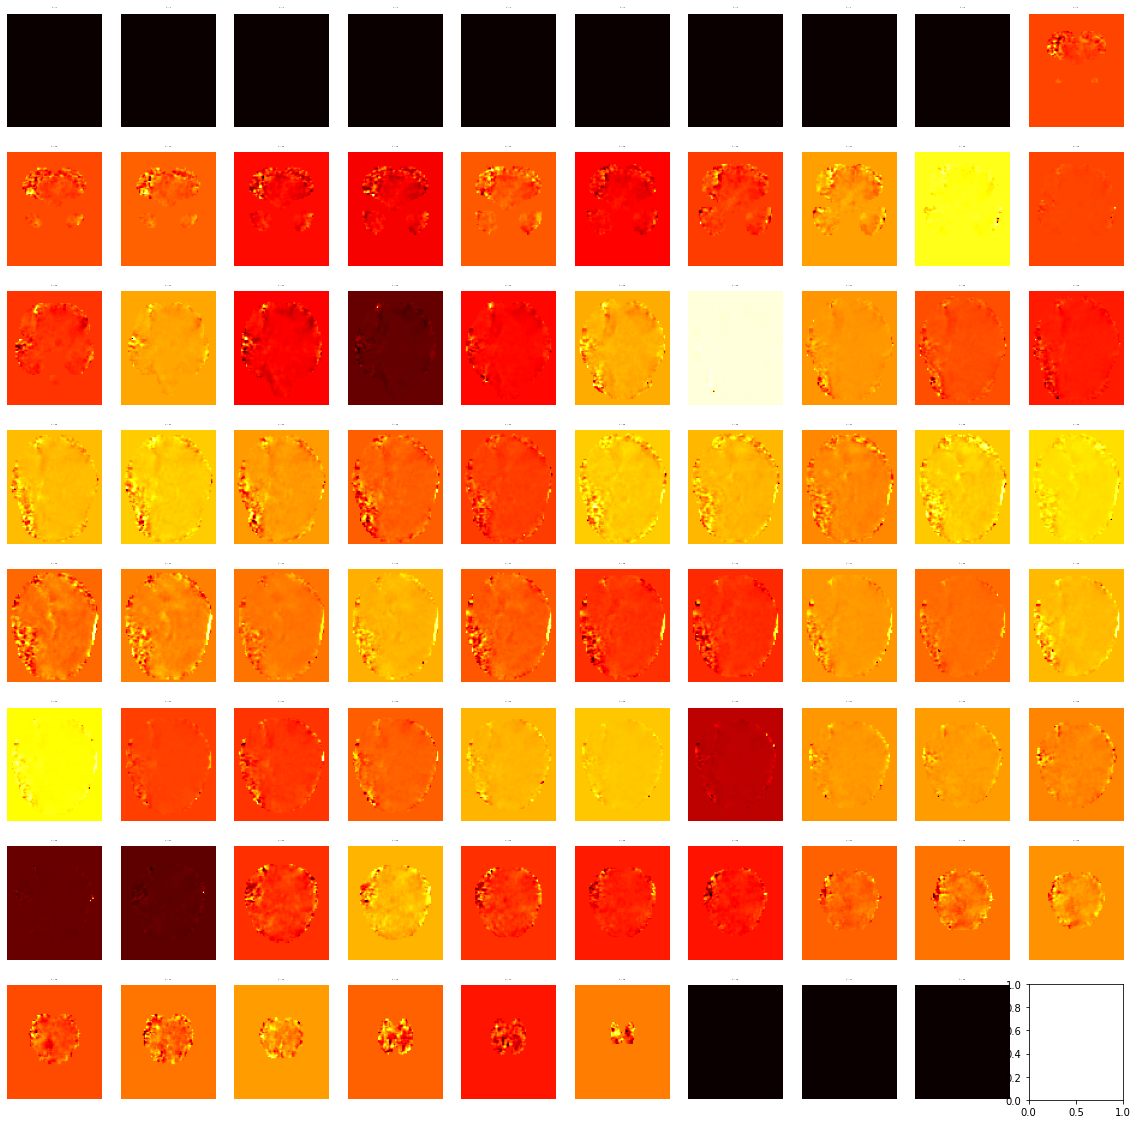

In [84]:
from matplotlib import patches
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=10, nrows=8, figsize=(20, 20))  # 20 timepoints
# Loop over the first 20 volumes/timepoints
for t, ax in enumerate(axes.flatten()):    
    ax.imshow(bmap2[:, :, t].T, cmap='hot')#, origin='lower')  # index with t!
    rect = patches.Rectangle((38, 20), 2, 2, linewidth=2, edgecolor='r', facecolor='black')
    #ax.add_patch(rect)
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=2)
fig.set_facecolor("gray")
fig.tight_layout()

#### LibSVM

#### OpenCV library
- https://docs.opencv.org/3.4/d1/d73/tutorial_introduction_to_svm.html


In [ ]:
%%time

# Train the SVM using openCV
svm = cv.ml.SVM_create()
svm.setType(cv.ml.SVM_C_SVC)
svm.setKernel(cv.ml.SVM_LINEAR)
svm.setTermCriteria((cv.TERM_CRITERIA_MAX_ITER, 100, 1e-6))
svm.train(X_train, cv.ml.ROW_SAMPLE, y_train)
